Воссоздание решения уравнения Аллена-Кана из статьи: "Sifan Wang, Shyam Sankaran. Respecting causality is all you need for training physics-informed neural networks"

In [1]:
import time

import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

from NN_pytorch_BVP.pinn import PeriodicLayer
#from NN_pytorch_BVP.bvp import *
#from NN_pytorch_BVP.training import *
#from NN_pytorch_BVP.formatted_table import FormattedTable

torch.manual_seed(2008)
device = 'cuda'
m = 10
omega = 2.0 * torch.pi / 2.0
domain = [0, -1, 1, 1]    # t_min, x_min, t_max, x_max
nt, nx = 100, 256
#n_epochs = 200000
n_epochs = 1000
lambda_ic, lambda_r = 100, 1

periodic_layer = PeriodicLayer(2, m=m, omega=omega, keep_dims=[1])
model = nn.Sequential(
    periodic_layer,
    nn.Linear(periodic_layer.out_features, 128), nn.Tanh(), 
    nn.Linear(128, 128), nn.Tanh(), 
    nn.Linear(128, 128), nn.Tanh(), 
    nn.Linear(128, 128), nn.Tanh(), 
    nn.Linear(128, 128), nn.Tanh(), 
    nn.Linear(128, 1)
).to(device=device)

def sample_points_2D(bounds: list[float], n: tuple, device: torch.device = torch.device("cpu")) -> torch.Tensor:
    """
    Generates a 2D grid of points.

    Args: 
        bounds (list[float]):
            A list of 4 floats with grid bounds: [x_min, y_min, x_max, y_max]
        n (tuple):
            A tuple of 2 integers: (nx, ny)
        device (torch.device):
            A PyTorch device to store output at

    Returns:
        xy (torch.tensor):
            A 2D tensor of shape (nx*ny, 2) where each row is a coordinate of a point
    """
    x_min, y_min, x_max, y_max = bounds
    nx, ny = n
    
    x = torch.linspace(x_min, x_max, nx, device=device)
    y = torch.linspace(y_min, y_max, ny, device=device)

    #X = x.repeat(ny)    # заполнять построчно 
    #Y = y.repeat_interleave(nx)
    X = x.repeat_interleave(ny)    # заполнять постолбцово
    Y = y.repeat(nx)

    return torch.stack([X, Y], dim=1)

tx = sample_points_2D(bounds=domain, n=(nt, nx), device=device)
tx_ic = tx[:nx, :].requires_grad_(True)
tx_r = tx[nx:, :].requires_grad_(True)

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
loss_r_arr = torch.zeros(n_epochs)
loss_ic_arr = torch.zeros(n_epochs)
training_start_time = time.time()
for epoch in range(1, n_epochs + 1):
    u_r = model(tx_r)
    u_ic = model(tx_ic)
    tmp = torch.autograd.grad(u_r, tx_r, grad_outputs=torch.ones_like(u_r), create_graph=True)[0]
    u_r_t = tmp[:, 0:1]
    u_r_x = tmp[:, 1:2]
    u_r_xx = torch.autograd.grad(u_r_x, tx_r, grad_outputs=torch.ones_like(u_r_x), create_graph=True)[0][:, 1:2]

    res_r = u_r_t - 0.0001*u_r_xx + 5*u_r**3 - 5*u_r
    res_ic = u_ic - tx_ic[:, 1:2]**2 * torch.cos(torch.pi*tx_ic[:, 1:2])

    optimizer.zero_grad()
    loss_r = torch.mean( res_r**2 )
    loss_ic = torch.mean( res_ic**2 )
    loss = lambda_ic * loss_ic + lambda_r * loss_r
    loss.backward()
    optimizer.step()
    loss_r_arr[epoch-1] = loss_r.detach().cpu()
    loss_ic_arr[epoch-1] = loss_ic.detach().cpu()
    
    if epoch == 1 or epoch % 100 == 0:
        print(f"epoch = {epoch:6d}, loss_ic = {loss_ic_arr[epoch-1]:10.4e}, loss_r = {loss_r_arr[epoch-1]:10.4e}")

training_time = time.time() - training_start_time
print(f"Training took {int(training_time) // 3600} hour(s), " 
      f"{ (int(training_time) % 3600) // 60 } minute(s) and "
      f"{ (training_time % 3600) % 60:.2f} second(s)")

d:\Учёба\adf\Скрипты\NN_pytorch_BVP\.venv\Lib\site-packages\torch\autograd\graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch =      1, loss_ic = 1.7469e-01, loss_r = 2.2415e-01
epoch =    100, loss_ic = 1.0303e-01, loss_r = 3.2366e-01
epoch =    200, loss_ic = 1.2106e-02, loss_r = 9.2450e-01
epoch =    300, loss_ic = 8.5769e-03, loss_r = 2.4411e-01
epoch =    400, loss_ic = 7.0355e-03, loss_r = 1.9031e-01
epoch =    500, loss_ic = 6.6975e-03, loss_r = 1.7858e-01
epoch =    600, loss_ic = 4.8771e-03, loss_r = 1.3546e-01
epoch =    700, loss_ic = 4.7612e-03, loss_r = 1.0180e-01
epoch =    800, loss_ic = 2.5066e-03, loss_r = 9.5855e-02
epoch =    900, loss_ic = 1.5711e-03, loss_r = 7.7065e-02
epoch =   1000, loss_ic = 1.2358e-03, loss_r = 6.8219e-02
Training took 0 hour(s), 1 minute(s) and 24.68 second(s)


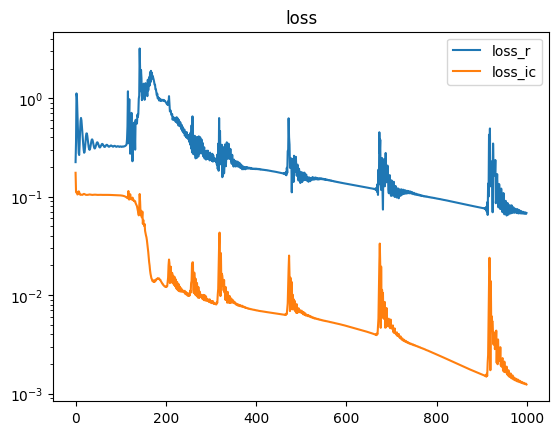

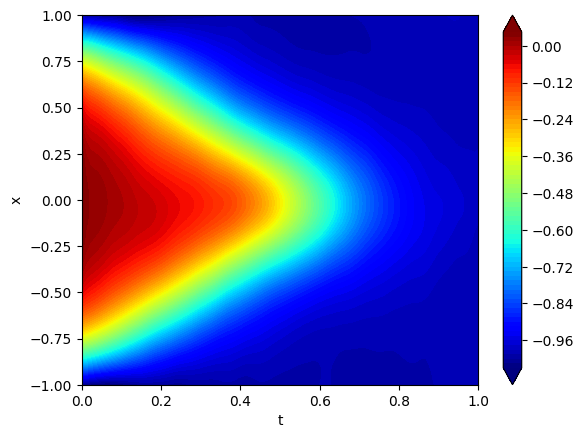

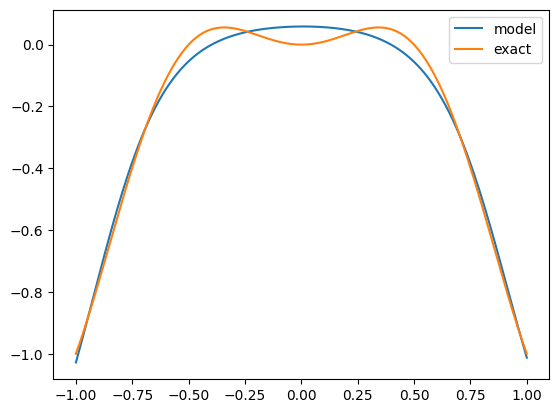

In [2]:
with torch.no_grad():
    plt.semilogy(loss_r_arr, label="loss_r")
    plt.semilogy(loss_ic_arr, label="loss_ic")
    plt.legend()
    plt.title("loss")
    plt.show()

    model = model.to('cpu')
    tx = tx.to('cpu')
    tx_ic = tx_ic.to('cpu')

    fig, ax = plt.subplots()
    triang = tri.Triangulation(tx[:, 0], tx[:, 1])
    tcf = plt.tricontourf(triang, model(tx).squeeze(), levels=80, extend='both', cmap='jet')
    fig.colorbar(tcf)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.show()

    plt.plot(tx_ic[:, 1:2], (model(tx_ic)).squeeze(), label="model")
    plt.plot(tx_ic[:, 1:2], (tx_ic[:, 1:2]**2 * torch.cos(torch.pi*tx_ic[:, 1:2])).squeeze(), label="exact")
    plt.legend()
    plt.show()